In [ ]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import load_model


2024-11-21 20:42:17.172410: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 20:42:17.299871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732250537.421523  397490 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732250537.457239  397490 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 20:42:17.615076: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
image_path = 'test/sentinel2_visual.tif'
model_path = 'models/11-16.keras'
output_dir = 'output'
SIZE = 128
THRESHOLD = 0.4

In [ ]:
image = np.asarray(Image.open(image_path)).astype('float')/255.

h, w = image.shape[:2]

print(f"Image dimensions: {h} x {w}")

n_h = int(np.ceil(h / SIZE))
n_w = int(np.ceil(w / SIZE))

print(f"Number of tiles: {n_h} x {n_w}")

padded_h = n_h * SIZE
padded_w = n_w * SIZE

padded_image = np.zeros((padded_h, padded_w, 3))
padded_image[:h, :w, :] = image

print(f"Padded image dimensions: {padded_h} x {padded_w}")

tiles = []
positions = []
for i in range(n_h):
    for j in range(n_w):
        start_h = i * SIZE
        start_w = j * SIZE
        tile = padded_image[start_h:start_h + SIZE, start_w:start_w + SIZE].copy()
        tiles.append(tile)
        positions.append((start_h, start_w))

padded_shape = (padded_h, padded_w)
original_shape = (h, w)

print(f"Created {len(tiles)} tiles")

Image dimensions: 10980 x 10980
Number of tiles: 86 x 86
Padded image dimensions: 11008 x 11008
Created 7396 tiles


In [4]:
model = load_model(model_path)

I0000 00:00:1732250545.766870  397490 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9274 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [ ]:
predictions = []
for tile in tqdm(tiles):
    tile_batch = np.expand_dims(tile, 0)
    pred = model.predict(tile_batch, verbose=0)
    predictions.append(pred[0])

100%|██████████| 10/10 [00:00<00:00, 34.66it/s]


In [28]:
full_image = np.zeros((padded_shape[0], padded_shape[1]))
for pred, (start_h, start_w) in zip(predictions, positions):
    # Get the prediction mask (removing extra dimensions)
    pred_mask = pred[:, :, 0]  # Take first channel of prediction
    full_image[start_h:start_h + SIZE, start_w:start_w + SIZE] = pred_mask

# Crop back to original size
full_prediction = full_image[:original_shape[0], :original_shape[1]]

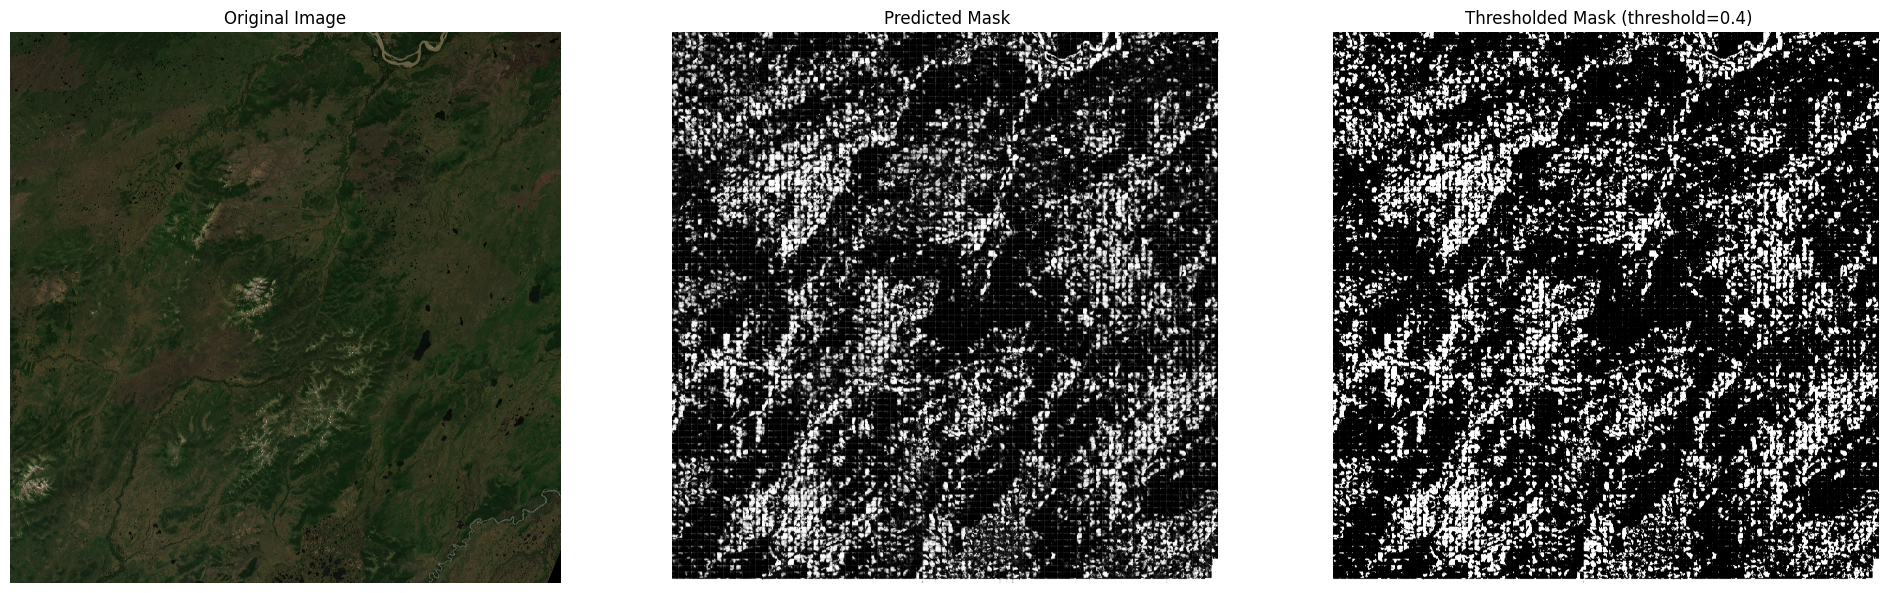

In [30]:

threshold_mask = full_prediction > THRESHOLD
    
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(full_prediction, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(threshold_mask, cmap='gray')
plt.title(f'Thresholded Mask (threshold={THRESHOLD})')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save the masks with correct orientation
base_filename = os.path.splitext(os.path.basename(image_path))[0]

# Save predicted mask
predicted_mask_path = os.path.join(output_dir, f'{base_filename}_predicted_mask.png')
plt.imsave(predicted_mask_path, 
          full_prediction, 
          cmap='gray',
          vmin=0,
          vmax=1)
print(f"Saved predicted mask to: {predicted_mask_path}")

# Save thresholded mask
thresholded_mask_path = os.path.join(output_dir, f'{base_filename}_thresholded_mask.png')
plt.imsave(thresholded_mask_path, 
          threshold_mask, 
          cmap='gray')
print(f"Saved thresholded mask to: {thresholded_mask_path}")

Saved predicted mask to: output/sentinel2_visual_predicted_mask.png
Saved thresholded mask to: output/sentinel2_visual_thresholded_mask.png
